<a href="https://colab.research.google.com/github/HermonaDev/Flora-Guard/blob/main/FloraGuard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

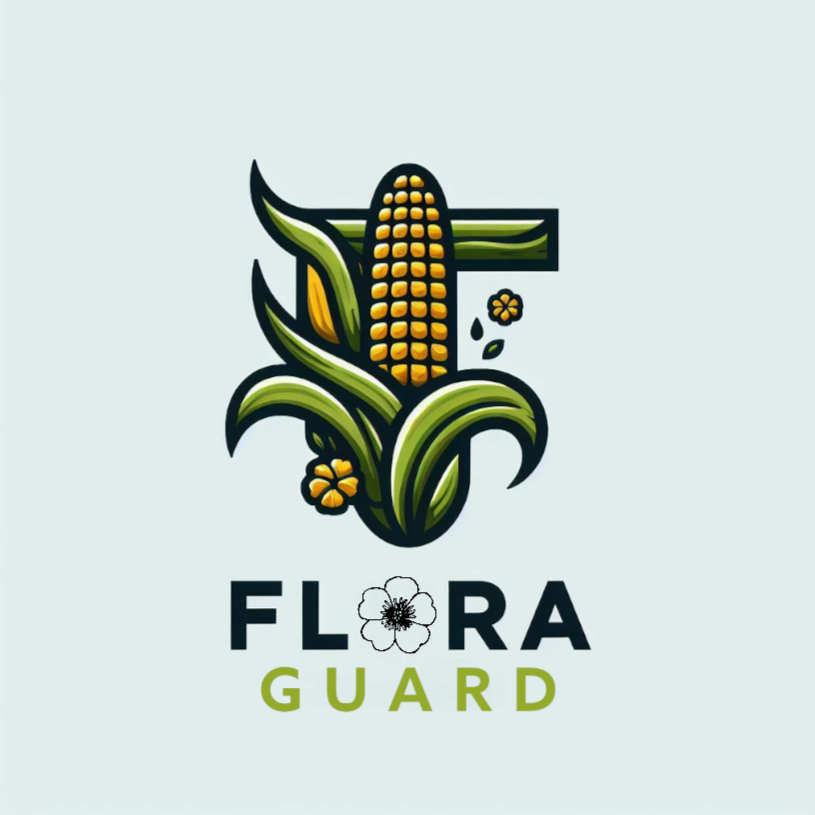

## Background
Getting affected by a disease is very common in plants due to various factors such as fertilizers, cultural practices followed, environmental conditions, etc. These diseases hurt agricultural yield and eventually the economy based on it.
Any technique or method to overcome this problem and getting a warning before the plants are infected would aid farmers to efficiently cultivate crops or plants, both qualitatively and quantitatively. Thus, disease detection in plants plays a very important role in agriculture.

# Introduction

This project tries to build a model using the power of **Keras**, a high-level neural networks API, capable of running on top of TensorFlow. It leverages the **MobileNet architecture**, known for its efficiency and performance, making the model lightweight yet incredibly powerful.

The model is deployed using **TensorFlow**, the world's most comprehensive and flexible platform for machine learning. This allows the model to learn from vast amounts of data and make accurate predictions, all while being scalable and robust.

With our Plant Disease Detection Model, diagnosing plant diseases is as simple as taking a photo. The model analyzes the image, identifies potential diseases, and provides results in seconds. This rapid and precise detection can save crops, increase yield, and ultimately feed more people.

We use a publicly available and quite famous, the PlantVillage Dataset


## Libraries
We import all the necessary libraries required to process the data and build the classification model.

In [86]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D

################

import cv2
import PIL
from tensorflow.python import keras
import warnings
import argparse
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


## Mounting google drive

The first time running the notebook will require you to allow access to your drive from colab

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
cd '/content/drive/My Drive/FloraGuard'

/content/drive/MyDrive/FloraGuard


In [89]:
!mkdir config datasets checkpoints models

mkdir: cannot create directory ‘config’: File exists
mkdir: cannot create directory ‘datasets’: File exists
mkdir: cannot create directory ‘checkpoints’: File exists
mkdir: cannot create directory ‘models’: File exists


In [90]:
cd '/content/drive/My Drive/FloraGuard/config'

/content/drive/My Drive/FloraGuard/config


In [91]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/FloraGuard/config"

Download Dataset

In [92]:
cd '/content/drive/My Drive/FloraGuard/datasets'

/content/drive/My Drive/FloraGuard/datasets


In [93]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

100% 2.03G/2.04G [00:36<00:00, 79.1MB/s]
100% 2.04G/2.04G [00:36<00:00, 59.7MB/s]


Unzip Data

In [95]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e6938d9-1ab0-4728-993c-1069b66ce73b___UF.GRC_YLCV_Lab 02727_final_mas

In [96]:
!pwd

/content/drive/MyDrive/FloraGuard/datasets


Split the Data

In [97]:
pip install split-folders[full]

In [98]:
import splitfolders

In [99]:
input_file="plantvillage dataset/color"
output_file="plantvillage dataset splitted"

In [100]:
splitfolders.ratio(input_file, output=output_file, seed=42, ratio=(.7,.2,.1), group_prefix=None)

Copying files: 54305 files [1:39:24,  9.10 files/s]


In [101]:
!pwd

/content/drive/MyDrive/FloraGuard/datasets


In [102]:
base_path = './plantvillage dataset splitted'

train_data_dir = base_path + "/train"
val_data_dir = base_path + "/val"

!dir

plantvillage\ dataset  plantvillage\ dataset\ splitted


In [103]:
len(os.listdir(os.path.join(base_path, 'train')))

38

In [104]:
img_size, batch_size, shuffle_size = 224, 64, 1000
img_shape = (img_size, img_size, 3)

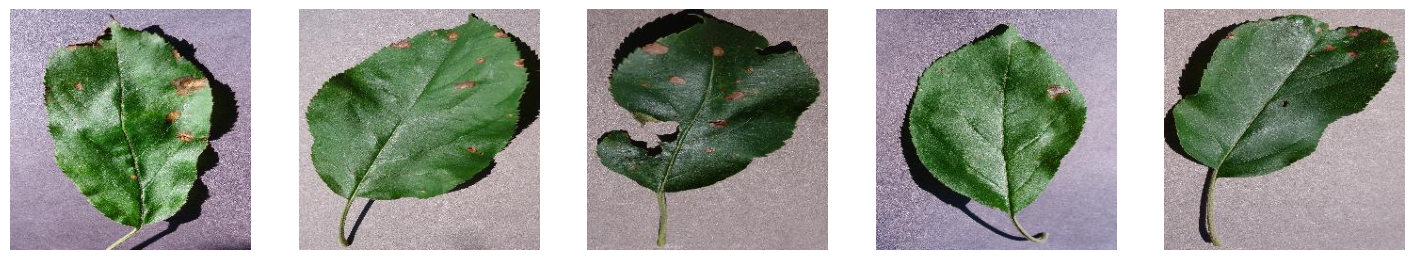

In [105]:
fig,axes = plt.subplots(1,5, figsize=(18,18))
images = os.listdir(os.path.join(base_path, 'train/Apple___Black_rot'))
for _ in range(5):
  ax = axes[_]
  image_path = base_path+'/train/Apple___Black_rot/'+images[_]
  img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
  ax.imshow(img)
  ax.axis('off')
plt.show()

## Data Augmentation & Preprocessing

In [106]:
gen = ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function=preprocess_input
)

train_datagen = gen.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_size, img_size)
)

val_datagen = gen.flow_from_directory(
    directory=val_data_dir,
    target_size=(img_size, img_size)
)

Found 37997 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


## Saving the dataset labels
The generators has an attribute named `class_indices` that contains the data labels that have been supplied by keras.

We save this into a variable since we will require it later.

In [107]:
labels = train_datagen.class_indices

Exception ignored in: <function _xla_gc_callback at 0x7c12d012dfc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


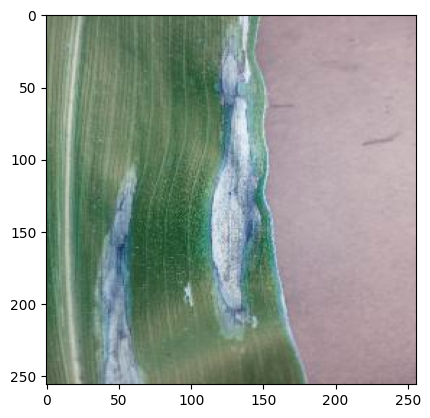

In [108]:
img = train_datagen.filepaths[np.random.random_integers(low=0, high=train_datagen.samples)]
img = cv2.imread(img)
plt.imshow(img)

In [109]:
import json
with open('/content/drive/My Drive/FloraGuard/checkpoints/labels.json','w') as f:
  json.dump(labels, f)

## Building the model with MobileNetV2
Keras comes packed with some models and for our case we will be using the predesigned MobileNetV2. We will be applying **Transfer Learning**

In [110]:
#The model starts with a standard convolution (Conv2D) layer followed by batch normalization (BatchNormalization) and ReLU activation (ReLU). This is followed by a depthwise convolution (DepthwiseConv2D), which is a space-saving operation that performs a convolution on each input channel separately. The depthwise convolution is also followed by batch normalization and ReLU activation.
mobile_net = MobileNetV2(weights='imagenet', include_top=False, input_shape=img_shape)

mobile_net.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

## Fine Tuning the model


In [111]:
x = mobile_net.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(38, activation='softmax')(x)


model = Model(mobile_net.input, x)

for layer in model.layers[:-23]:
    layer.trainable = False

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [112]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

In [113]:
checkpoint = ModelCheckpoint("pdd_mobilenet2_v1.h5.keras", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [114]:
step_size = 50

In [115]:
model_history = model.fit(
    train_datagen,
    epochs=10,
    steps_per_epoch=step_size,
    validation_data=val_datagen,
    validation_steps=25,
    callbacks = [checkpoint, early]
)

Epoch 1/10


 1/50 [..............................] - ETA: 10:41 - loss: 3.7104 - acc: 0.0000e+00

 2/50 [>.............................] - ETA: 6:12 - loss: 3.6455 - acc: 0.0469     

 3/50 [>.............................] - ETA: 4:11 - loss: 3.5538 - acc: 0.0833

 4/50 [=>............................] - ETA: 4:28 - loss: 3.5226 - acc: 0.1094

 5/50 [==>...........................] - ETA: 3:48 - loss: 3.4591 - acc: 0.1375

 6/50 [==>...........................] - ETA: 3:24 - loss: 3.4019 - acc: 0.1719

 7/50 [===>..........................] - ETA: 3:08 - loss: 3.3283 - acc: 0.2143

 8/50 [===>..........................] - ETA: 3:04 - loss: 3.2835 - acc: 0.2344

 9/50 [====>.........................] - ETA: 2:54 - loss: 3.2667 - acc: 0.2396

10/50 [=====>........................] - ETA: 2:44 - loss: 3.2457 - acc: 0.2406

11/50 [=====>........................] - ETA: 2:35 - loss: 3.1768 - acc: 0.2642

12/50 [======>.......................] - ETA: 2:27 - loss: 3.1208 - acc: 0.2734

13/50 [======>.......................] - ETA: 2:25 - loss: 3.1264 - acc: 0.2620

14/50 [=======>......................] - ETA: 2:18 - loss: 3.1212 - acc: 0.2567

15/50 [========>.....................] - ETA: 2:12 - loss: 3.1007 - acc: 0.2583

16/50 [========>.....................] - ETA: 2:05 - loss: 3.0846 - acc: 0.2598

17/50 [=========>....................] - ETA: 2:03 - loss: 3.0456 - acc: 0.2665

18/50 [=========>....................] - ETA: 2:00 - loss: 3.0285 - acc: 0.2708

19/50 [==========>...................] - ETA: 1:54 - loss: 3.0016 - acc: 0.2780

20/50 [===========>..................] - ETA: 1:49 - loss: 2.9764 - acc: 0.2797

21/50 [===========>..................] - ETA: 1:45 - loss: 2.9549 - acc: 0.2812

22/50 [============>.................] - ETA: 1:42 - loss: 2.9016 - acc: 0.2955

23/50 [============>.................] - ETA: 1:37 - loss: 2.8582 - acc: 0.3057

24/50 [=============>................] - ETA: 1:33 - loss: 2.8401 - acc: 0.3112

25/50 [==============>...............] - ETA: 1:29 - loss: 2.8113 - acc: 0.3162

26/50 [==============>...............] - ETA: 1:26 - loss: 2.7888 - acc: 0.3197

27/50 [===============>..............] - ETA: 1:22 - loss: 2.7677 - acc: 0.3218

28/50 [===============>..............] - ETA: 1:18 - loss: 2.7590 - acc: 0.3203

29/50 [================>.............] - ETA: 1:13 - loss: 2.7284 - acc: 0.3276

30/50 [=================>............] - ETA: 1:10 - loss: 2.7118 - acc: 0.3313

31/50 [=================>............] - ETA: 1:07 - loss: 2.6844 - acc: 0.3397

32/50 [==================>...........] - ETA: 1:03 - loss: 2.6606 - acc: 0.3467

33/50 [==================>...........] - ETA: 59s - loss: 2.6346 - acc: 0.3542 

34/50 [===================>..........] - ETA: 55s - loss: 2.6075 - acc: 0.3612

35/50 [====================>.........] - ETA: 52s - loss: 2.5860 - acc: 0.3679

36/50 [====================>.........] - ETA: 48s - loss: 2.5670 - acc: 0.3767

37/50 [=====================>........] - ETA: 45s - loss: 2.5406 - acc: 0.3877

38/50 [=====================>........] - ETA: 41s - loss: 2.5194 - acc: 0.3931

39/50 [======================>.......] - ETA: 38s - loss: 2.5034 - acc: 0.3982

40/50 [=======================>......] - ETA: 34s - loss: 2.4887 - acc: 0.4023

41/50 [=======================>......] - ETA: 31s - loss: 2.4844 - acc: 0.4024

42/50 [========================>.....] - ETA: 27s - loss: 2.4713 - acc: 0.4055

43/50 [========================>.....] - ETA: 24s - loss: 2.4610 - acc: 0.4092

44/50 [=========================>....] - ETA: 20s - loss: 2.4554 - acc: 0.4112

45/50 [==========================>...] - ETA: 17s - loss: 2.4359 - acc: 0.4160

46/50 [==========================>...] - ETA: 13s - loss: 2.4098 - acc: 0.4232

47/50 [===========================>..] - ETA: 10s - loss: 2.3937 - acc: 0.4289

48/50 [===========================>..] - ETA: 6s - loss: 2.3747 - acc: 0.4349 

49/50 [============================>.] - ETA: 3s - loss: 2.3606 - acc: 0.4388

50/50 [==============================] - 267s 5s/step - loss: 2.3417 - acc: 0.4425 - val_loss: 1.8572 - val_acc: 0.5163
Epoch 2/10


 1/50 [..............................] - ETA: 2:51 - loss: 1.7233 - acc: 0.6250

 2/50 [>.............................] - ETA: 3:00 - loss: 1.3841 - acc: 0.7188

 3/50 [>.............................] - ETA: 2:47 - loss: 1.3094 - acc: 0.7292

 4/50 [=>............................] - ETA: 2:30 - loss: 1.2426 - acc: 0.7422

 5/50 [==>...........................] - ETA: 2:25 - loss: 1.2352 - acc: 0.7500

 6/50 [==>...........................] - ETA: 2:18 - loss: 1.2805 - acc: 0.7292

 7/50 [===>..........................] - ETA: 2:25 - loss: 1.2696 - acc: 0.7411

 8/50 [===>..........................] - ETA: 2:20 - loss: 1.2324 - acc: 0.7461

 9/50 [====>.........................] - ETA: 2:14 - loss: 1.2224 - acc: 0.7465

10/50 [=====>........................] - ETA: 2:08 - loss: 1.1842 - acc: 0.7531

11/50 [=====>........................] - ETA: 2:07 - loss: 1.1999 - acc: 0.7443

12/50 [======>.......................] - ETA: 2:06 - loss: 1.1968 - acc: 0.7422

13/50 [======>.......................] - ETA: 2:01 - loss: 1.1783 - acc: 0.7476

14/50 [=======>......................] - ETA: 1:56 - loss: 1.1664 - acc: 0.7522

15/50 [========>.....................] - ETA: 1:52 - loss: 1.1852 - acc: 0.7479

16/50 [========>.....................] - ETA: 1:52 - loss: 1.1808 - acc: 0.7461

17/50 [=========>....................] - ETA: 1:47 - loss: 1.1831 - acc: 0.7408

18/50 [=========>....................] - ETA: 1:43 - loss: 1.1794 - acc: 0.7344

19/50 [==========>...................] - ETA: 1:39 - loss: 1.1604 - acc: 0.7368

20/50 [===========>..................] - ETA: 1:37 - loss: 1.1724 - acc: 0.7281

21/50 [===========>..................] - ETA: 1:35 - loss: 1.1801 - acc: 0.7262

22/50 [============>.................] - ETA: 1:30 - loss: 1.1723 - acc: 0.7301

23/50 [============>.................] - ETA: 1:27 - loss: 1.1678 - acc: 0.7296

24/50 [=============>................] - ETA: 1:23 - loss: 1.1725 - acc: 0.7266

25/50 [==============>...............] - ETA: 1:21 - loss: 1.1630 - acc: 0.7275

26/50 [==============>...............] - ETA: 1:18 - loss: 1.1670 - acc: 0.7272

27/50 [===============>..............] - ETA: 1:14 - loss: 1.1706 - acc: 0.7257

28/50 [===============>..............] - ETA: 1:10 - loss: 1.1677 - acc: 0.7243

29/50 [================>.............] - ETA: 1:07 - loss: 1.1647 - acc: 0.7241

30/50 [=================>............] - ETA: 1:05 - loss: 1.1545 - acc: 0.7281

31/50 [=================>............] - ETA: 1:01 - loss: 1.1576 - acc: 0.7268

32/50 [==================>...........] - ETA: 57s - loss: 1.1469 - acc: 0.7305 

33/50 [==================>...........] - ETA: 54s - loss: 1.1413 - acc: 0.7311

34/50 [===================>..........] - ETA: 52s - loss: 1.1337 - acc: 0.7298

35/50 [====================>.........] - ETA: 48s - loss: 1.1167 - acc: 0.7339

36/50 [====================>.........] - ETA: 45s - loss: 1.1179 - acc: 0.7335

37/50 [=====================>........] - ETA: 41s - loss: 1.1151 - acc: 0.7331

38/50 [=====================>........] - ETA: 38s - loss: 1.1152 - acc: 0.7336

39/50 [======================>.......] - ETA: 35s - loss: 1.1063 - acc: 0.7348

40/50 [=======================>......] - ETA: 32s - loss: 1.1026 - acc: 0.7359

41/50 [=======================>......] - ETA: 29s - loss: 1.0949 - acc: 0.7378

42/50 [========================>.....] - ETA: 25s - loss: 1.0971 - acc: 0.7359

43/50 [========================>.....] - ETA: 22s - loss: 1.0893 - acc: 0.7369

44/50 [=========================>....] - ETA: 19s - loss: 1.0879 - acc: 0.7365

45/50 [==========================>...] - ETA: 16s - loss: 1.0847 - acc: 0.7375

46/50 [==========================>...] - ETA: 12s - loss: 1.0798 - acc: 0.7378

47/50 [===========================>..] - ETA: 9s - loss: 1.0727 - acc: 0.7400 

48/50 [===========================>..] - ETA: 6s - loss: 1.0742 - acc: 0.7383

49/50 [============================>.] - ETA: 3s - loss: 1.0668 - acc: 0.7398

50/50 [==============================] - 243s 5s/step - loss: 1.0591 - acc: 0.7406 - val_loss: 1.5001 - val_acc: 0.5775
Epoch 3/10


 1/50 [..............................] - ETA: 2:38 - loss: 0.8765 - acc: 0.7812

 2/50 [>.............................] - ETA: 2:27 - loss: 0.7033 - acc: 0.8125

 3/50 [>.............................] - ETA: 2:59 - loss: 0.7676 - acc: 0.7917

 4/50 [=>............................] - ETA: 2:48 - loss: 0.6825 - acc: 0.8438

 5/50 [==>...........................] - ETA: 2:33 - loss: 0.6904 - acc: 0.8313

 6/50 [==>...........................] - ETA: 2:22 - loss: 0.6693 - acc: 0.8333

 7/50 [===>..........................] - ETA: 2:22 - loss: 0.6705 - acc: 0.8304

 8/50 [===>..........................] - ETA: 2:23 - loss: 0.7065 - acc: 0.8125

 9/50 [====>.........................] - ETA: 2:16 - loss: 0.6775 - acc: 0.8264

10/50 [=====>........................] - ETA: 2:11 - loss: 0.7015 - acc: 0.8125

11/50 [=====>........................] - ETA: 2:06 - loss: 0.6963 - acc: 0.8153

12/50 [======>.......................] - ETA: 2:07 - loss: 0.6724 - acc: 0.8229

13/50 [======>.......................] - ETA: 2:03 - loss: 0.6803 - acc: 0.8221

14/50 [=======>......................] - ETA: 1:58 - loss: 0.6737 - acc: 0.8237

15/50 [========>.....................] - ETA: 1:52 - loss: 0.6943 - acc: 0.8167

16/50 [========>.....................] - ETA: 1:50 - loss: 0.6837 - acc: 0.8203

17/50 [=========>....................] - ETA: 1:48 - loss: 0.6958 - acc: 0.8107

18/50 [=========>....................] - ETA: 1:44 - loss: 0.7125 - acc: 0.8021

19/50 [==========>...................] - ETA: 1:40 - loss: 0.7236 - acc: 0.7928

20/50 [===========>..................] - ETA: 1:36 - loss: 0.7097 - acc: 0.7953

21/50 [===========>..................] - ETA: 1:35 - loss: 0.6995 - acc: 0.7976

22/50 [============>.................] - ETA: 1:32 - loss: 0.6961 - acc: 0.7997

23/50 [============>.................] - ETA: 1:28 - loss: 0.6977 - acc: 0.8003

24/50 [=============>................] - ETA: 1:24 - loss: 0.6955 - acc: 0.8008

25/50 [==============>...............] - ETA: 1:20 - loss: 0.6930 - acc: 0.8037

26/50 [==============>...............] - ETA: 1:18 - loss: 0.6931 - acc: 0.8029

27/50 [===============>..............] - ETA: 1:14 - loss: 0.6964 - acc: 0.8032

28/50 [===============>..............] - ETA: 1:11 - loss: 0.6919 - acc: 0.8025

29/50 [================>.............] - ETA: 1:07 - loss: 0.6851 - acc: 0.8039

30/50 [=================>............] - ETA: 1:05 - loss: 0.6845 - acc: 0.8062

31/50 [=================>............] - ETA: 1:01 - loss: 0.6760 - acc: 0.8095

32/50 [==================>...........] - ETA: 58s - loss: 0.6666 - acc: 0.8135 

33/50 [==================>...........] - ETA: 54s - loss: 0.6706 - acc: 0.8134

34/50 [===================>..........] - ETA: 51s - loss: 0.6686 - acc: 0.8134

35/50 [====================>.........] - ETA: 50s - loss: 0.6656 - acc: 0.8143

36/50 [====================>.........] - ETA: 47s - loss: 0.6618 - acc: 0.8160

37/50 [=====================>........] - ETA: 44s - loss: 0.6584 - acc: 0.8176

38/50 [=====================>........] - ETA: 41s - loss: 0.6577 - acc: 0.8174

39/50 [======================>.......] - ETA: 37s - loss: 0.6534 - acc: 0.8189

40/50 [=======================>......] - ETA: 34s - loss: 0.6491 - acc: 0.8203

41/50 [=======================>......] - ETA: 30s - loss: 0.6437 - acc: 0.8209

42/50 [========================>.....] - ETA: 27s - loss: 0.6480 - acc: 0.8185

43/50 [========================>.....] - ETA: 23s - loss: 0.6414 - acc: 0.8205

44/50 [=========================>....] - ETA: 20s - loss: 0.6363 - acc: 0.8224

45/50 [==========================>...] - ETA: 16s - loss: 0.6356 - acc: 0.8215

46/50 [==========================>...] - ETA: 13s - loss: 0.6332 - acc: 0.8207

47/50 [===========================>..] - ETA: 10s - loss: 0.6321 - acc: 0.8225

48/50 [===========================>..] - ETA: 6s - loss: 0.6284 - acc: 0.8236 

49/50 [============================>.] - ETA: 3s - loss: 0.6264 - acc: 0.8233

50/50 [==============================] - 251s 5s/step - loss: 0.6183 - acc: 0.8263 - val_loss: 1.2016 - val_acc: 0.6637
Epoch 4/10


 1/50 [..............................] - ETA: 2:37 - loss: 0.2617 - acc: 0.9688

 2/50 [>.............................] - ETA: 2:25 - loss: 0.4393 - acc: 0.8594

 3/50 [>.............................] - ETA: 2:58 - loss: 0.3993 - acc: 0.8542

 4/50 [=>............................] - ETA: 2:47 - loss: 0.3814 - acc: 0.8828

 5/50 [==>...........................] - ETA: 2:30 - loss: 0.4300 - acc: 0.8562

 6/50 [==>...........................] - ETA: 2:23 - loss: 0.4230 - acc: 0.8646

 7/50 [===>..........................] - ETA: 2:20 - loss: 0.3827 - acc: 0.8839

 8/50 [===>..........................] - ETA: 2:22 - loss: 0.3803 - acc: 0.8867

 9/50 [====>.........................] - ETA: 2:16 - loss: 0.4121 - acc: 0.8819

10/50 [=====>........................] - ETA: 2:11 - loss: 0.4032 - acc: 0.8875

11/50 [=====>........................] - ETA: 2:06 - loss: 0.3983 - acc: 0.8920

12/50 [======>.......................] - ETA: 2:06 - loss: 0.3836 - acc: 0.8984

13/50 [======>.......................] - ETA: 2:04 - loss: 0.4092 - acc: 0.8918

14/50 [=======>......................] - ETA: 1:58 - loss: 0.3966 - acc: 0.8929

15/50 [========>.....................] - ETA: 1:53 - loss: 0.4088 - acc: 0.8875

16/50 [========>.....................] - ETA: 1:52 - loss: 0.3907 - acc: 0.8945

17/50 [=========>....................] - ETA: 1:50 - loss: 0.3850 - acc: 0.8934

18/50 [=========>....................] - ETA: 1:46 - loss: 0.3991 - acc: 0.8889

19/50 [==========>...................] - ETA: 1:42 - loss: 0.3929 - acc: 0.8898

20/50 [===========>..................] - ETA: 1:38 - loss: 0.3877 - acc: 0.8922

21/50 [===========>..................] - ETA: 1:36 - loss: 0.3806 - acc: 0.8943

22/50 [============>.................] - ETA: 1:33 - loss: 0.3744 - acc: 0.8991

23/50 [============>.................] - ETA: 1:29 - loss: 0.3676 - acc: 0.8995

24/50 [=============>................] - ETA: 1:25 - loss: 0.3671 - acc: 0.9010

25/50 [==============>...............] - ETA: 1:22 - loss: 0.3784 - acc: 0.8950

26/50 [==============>...............] - ETA: 1:19 - loss: 0.3902 - acc: 0.8894

27/50 [===============>..............] - ETA: 1:15 - loss: 0.3892 - acc: 0.8912

28/50 [===============>..............] - ETA: 1:12 - loss: 0.3952 - acc: 0.8895

29/50 [================>.............] - ETA: 1:08 - loss: 0.3965 - acc: 0.8879

30/50 [=================>............] - ETA: 1:05 - loss: 0.3952 - acc: 0.8875

31/50 [=================>............] - ETA: 1:02 - loss: 0.3995 - acc: 0.8861

32/50 [==================>...........] - ETA: 59s - loss: 0.3959 - acc: 0.8867 

33/50 [==================>...........] - ETA: 55s - loss: 0.3990 - acc: 0.8854

34/50 [===================>..........] - ETA: 52s - loss: 0.3999 - acc: 0.8860

35/50 [====================>.........] - ETA: 49s - loss: 0.4018 - acc: 0.8866

36/50 [====================>.........] - ETA: 46s - loss: 0.3982 - acc: 0.8872

37/50 [=====================>........] - ETA: 42s - loss: 0.3961 - acc: 0.8868

38/50 [=====================>........] - ETA: 39s - loss: 0.3976 - acc: 0.8857

39/50 [======================>.......] - ETA: 36s - loss: 0.3954 - acc: 0.8862

40/50 [=======================>......] - ETA: 32s - loss: 0.3968 - acc: 0.8852

41/50 [=======================>......] - ETA: 29s - loss: 0.3932 - acc: 0.8864

42/50 [========================>.....] - ETA: 26s - loss: 0.3936 - acc: 0.8862

43/50 [========================>.....] - ETA: 22s - loss: 0.3920 - acc: 0.8874

44/50 [=========================>....] - ETA: 19s - loss: 0.3894 - acc: 0.8885

45/50 [==========================>...] - ETA: 16s - loss: 0.3895 - acc: 0.8889

46/50 [==========================>...] - ETA: 13s - loss: 0.3862 - acc: 0.8893

47/50 [===========================>..] - ETA: 9s - loss: 0.3882 - acc: 0.8876 

48/50 [===========================>..] - ETA: 6s - loss: 0.3861 - acc: 0.8880

49/50 [============================>.] - ETA: 3s - loss: 0.3855 - acc: 0.8871

50/50 [==============================] - 246s 5s/step - loss: 0.3930 - acc: 0.8850 - val_loss: 0.9369 - val_acc: 0.7237
Epoch 5/10


 1/50 [..............................] - ETA: 3:12 - loss: 0.3245 - acc: 0.9375

 2/50 [>.............................] - ETA: 2:07 - loss: 0.3691 - acc: 0.9062

 3/50 [>.............................] - ETA: 2:42 - loss: 0.3364 - acc: 0.9271

 4/50 [=>............................] - ETA: 2:50 - loss: 0.3350 - acc: 0.9297

 5/50 [==>...........................] - ETA: 2:35 - loss: 0.3177 - acc: 0.9250

 6/50 [==>...........................] - ETA: 2:26 - loss: 0.3247 - acc: 0.9219

 7/50 [===>..........................] - ETA: 2:23 - loss: 0.3283 - acc: 0.9196

 8/50 [===>..........................] - ETA: 2:25 - loss: 0.3358 - acc: 0.9141

 9/50 [====>.........................] - ETA: 2:20 - loss: 0.3252 - acc: 0.9167

10/50 [=====>........................] - ETA: 2:13 - loss: 0.3328 - acc: 0.9125

11/50 [=====>........................] - ETA: 2:10 - loss: 0.3244 - acc: 0.9148

12/50 [======>.......................] - ETA: 2:11 - loss: 0.3372 - acc: 0.9115

13/50 [======>.......................] - ETA: 2:07 - loss: 0.3393 - acc: 0.9087

14/50 [=======>......................] - ETA: 2:02 - loss: 0.3405 - acc: 0.9062

15/50 [========>.....................] - ETA: 1:56 - loss: 0.3399 - acc: 0.9062

16/50 [========>.....................] - ETA: 1:54 - loss: 0.3316 - acc: 0.9082

17/50 [=========>....................] - ETA: 1:52 - loss: 0.3271 - acc: 0.9099

18/50 [=========>....................] - ETA: 1:46 - loss: 0.3265 - acc: 0.9062

19/50 [==========>...................] - ETA: 1:42 - loss: 0.3269 - acc: 0.9062

20/50 [===========>..................] - ETA: 1:38 - loss: 0.3320 - acc: 0.9047

21/50 [===========>..................] - ETA: 1:37 - loss: 0.3331 - acc: 0.9018

22/50 [============>.................] - ETA: 1:33 - loss: 0.3256 - acc: 0.9034

23/50 [============>.................] - ETA: 1:29 - loss: 0.3225 - acc: 0.9049

24/50 [=============>................] - ETA: 1:26 - loss: 0.3222 - acc: 0.9049

25/50 [==============>...............] - ETA: 1:23 - loss: 0.3195 - acc: 0.9062

26/50 [==============>...............] - ETA: 1:20 - loss: 0.3138 - acc: 0.9075

27/50 [===============>..............] - ETA: 1:16 - loss: 0.3160 - acc: 0.9062

28/50 [===============>..............] - ETA: 1:12 - loss: 0.3150 - acc: 0.9074

29/50 [================>.............] - ETA: 1:08 - loss: 0.3140 - acc: 0.9073

30/50 [=================>............] - ETA: 1:05 - loss: 0.3135 - acc: 0.9083

31/50 [=================>............] - ETA: 1:02 - loss: 0.3149 - acc: 0.9073

32/50 [==================>...........] - ETA: 59s - loss: 0.3216 - acc: 0.9053 

33/50 [==================>...........] - ETA: 55s - loss: 0.3218 - acc: 0.9044

34/50 [===================>..........] - ETA: 52s - loss: 0.3241 - acc: 0.9035

35/50 [====================>.........] - ETA: 49s - loss: 0.3237 - acc: 0.9018

36/50 [====================>.........] - ETA: 46s - loss: 0.3247 - acc: 0.9010

37/50 [=====================>........] - ETA: 42s - loss: 0.3225 - acc: 0.9020

38/50 [=====================>........] - ETA: 39s - loss: 0.3225 - acc: 0.9021

39/50 [======================>.......] - ETA: 36s - loss: 0.3213 - acc: 0.9030

40/50 [=======================>......] - ETA: 33s - loss: 0.3209 - acc: 0.9039

41/50 [=======================>......] - ETA: 29s - loss: 0.3289 - acc: 0.9009

42/50 [========================>.....] - ETA: 26s - loss: 0.3258 - acc: 0.9025

43/50 [========================>.....] - ETA: 23s - loss: 0.3368 - acc: 0.8997

44/50 [=========================>....] - ETA: 19s - loss: 0.3332 - acc: 0.9013

45/50 [==========================>...] - ETA: 16s - loss: 0.3327 - acc: 0.9007

46/50 [==========================>...] - ETA: 13s - loss: 0.3314 - acc: 0.9008

47/50 [===========================>..] - ETA: 9s - loss: 0.3289 - acc: 0.9016 

48/50 [===========================>..] - ETA: 6s - loss: 0.3311 - acc: 0.9017

49/50 [============================>.] - ETA: 3s - loss: 0.3291 - acc: 0.9031

50/50 [==============================] - 248s 5s/step - loss: 0.3338 - acc: 0.9025 - val_loss: 0.8699 - val_acc: 0.7575
Epoch 6/10


 1/50 [..............................] - ETA: 3:38 - loss: 0.4618 - acc: 0.8750

 2/50 [>.............................] - ETA: 2:12 - loss: 0.4087 - acc: 0.8750

 3/50 [>.............................] - ETA: 2:16 - loss: 0.3222 - acc: 0.9062

 4/50 [=>............................] - ETA: 2:22 - loss: 0.3591 - acc: 0.8906

 5/50 [==>...........................] - ETA: 2:31 - loss: 0.3484 - acc: 0.8875

 6/50 [==>...........................] - ETA: 2:27 - loss: 0.3286 - acc: 0.9010

 7/50 [===>..........................] - ETA: 2:19 - loss: 0.3350 - acc: 0.9018

 8/50 [===>..........................] - ETA: 2:16 - loss: 0.3269 - acc: 0.9062

 9/50 [====>.........................] - ETA: 2:19 - loss: 0.3327 - acc: 0.9062

10/50 [=====>........................] - ETA: 2:15 - loss: 0.3347 - acc: 0.9062

11/50 [=====>........................] - ETA: 2:11 - loss: 0.3327 - acc: 0.9062

12/50 [======>.......................] - ETA: 2:07 - loss: 0.3138 - acc: 0.9115

13/50 [======>.......................] - ETA: 2:08 - loss: 0.3229 - acc: 0.9135

14/50 [=======>......................] - ETA: 2:04 - loss: 0.3233 - acc: 0.9129

15/50 [========>.....................] - ETA: 1:58 - loss: 0.3218 - acc: 0.9125

16/50 [========>.....................] - ETA: 1:53 - loss: 0.3189 - acc: 0.9102

17/50 [=========>....................] - ETA: 1:52 - loss: 0.3121 - acc: 0.9118

18/50 [=========>....................] - ETA: 1:49 - loss: 0.3145 - acc: 0.9115

19/50 [==========>...................] - ETA: 1:45 - loss: 0.3126 - acc: 0.9112

20/50 [===========>..................] - ETA: 1:41 - loss: 0.3133 - acc: 0.9094

21/50 [===========>..................] - ETA: 1:38 - loss: 0.3142 - acc: 0.9062

22/50 [============>.................] - ETA: 1:35 - loss: 0.3096 - acc: 0.9062

23/50 [============>.................] - ETA: 1:31 - loss: 0.3126 - acc: 0.9049

24/50 [=============>................] - ETA: 1:27 - loss: 0.3183 - acc: 0.9036

25/50 [==============>...............] - ETA: 1:23 - loss: 0.3149 - acc: 0.9038

26/50 [==============>...............] - ETA: 1:21 - loss: 0.3197 - acc: 0.9038

27/50 [===============>..............] - ETA: 1:17 - loss: 0.3157 - acc: 0.9051

28/50 [===============>..............] - ETA: 1:14 - loss: 0.3193 - acc: 0.9051

29/50 [================>.............] - ETA: 1:10 - loss: 0.3176 - acc: 0.9041

30/50 [=================>............] - ETA: 1:07 - loss: 0.3193 - acc: 0.9042

31/50 [=================>............] - ETA: 1:04 - loss: 0.3217 - acc: 0.9032

32/50 [==================>...........] - ETA: 1:00 - loss: 0.3256 - acc: 0.9004

33/50 [==================>...........] - ETA: 57s - loss: 0.3222 - acc: 0.9015 

34/50 [===================>..........] - ETA: 54s - loss: 0.3207 - acc: 0.9017

35/50 [====================>.........] - ETA: 51s - loss: 0.3193 - acc: 0.9036

36/50 [====================>.........] - ETA: 47s - loss: 0.3238 - acc: 0.9045

37/50 [=====================>........] - ETA: 44s - loss: 0.3208 - acc: 0.9046

38/50 [=====================>........] - ETA: 40s - loss: 0.3202 - acc: 0.9054

39/50 [======================>.......] - ETA: 37s - loss: 0.3192 - acc: 0.9054

40/50 [=======================>......] - ETA: 34s - loss: 0.3149 - acc: 0.9062

41/50 [=======================>......] - ETA: 30s - loss: 0.3153 - acc: 0.9055

42/50 [========================>.....] - ETA: 26s - loss: 0.3151 - acc: 0.9055

43/50 [========================>.....] - ETA: 23s - loss: 0.3128 - acc: 0.9070

44/50 [=========================>....] - ETA: 20s - loss: 0.3085 - acc: 0.9091

45/50 [==========================>...] - ETA: 16s - loss: 0.3087 - acc: 0.9083

46/50 [==========================>...] - ETA: 13s - loss: 0.3076 - acc: 0.9076

47/50 [===========================>..] - ETA: 10s - loss: 0.3041 - acc: 0.9089

48/50 [===========================>..] - ETA: 6s - loss: 0.3031 - acc: 0.9095 

49/50 [============================>.] - ETA: 3s - loss: 0.3034 - acc: 0.9094

50/50 [==============================] - 251s 5s/step - loss: 0.3032 - acc: 0.9100 - val_loss: 0.7982 - val_acc: 0.7738
Epoch 7/10


 1/50 [..............................] - ETA: 3:07 - loss: 0.1172 - acc: 0.9688

 2/50 [>.............................] - ETA: 1:57 - loss: 0.3423 - acc: 0.9062

 3/50 [>.............................] - ETA: 2:14 - loss: 0.2948 - acc: 0.9167

 4/50 [=>............................] - ETA: 2:39 - loss: 0.2672 - acc: 0.9219

 5/50 [==>...........................] - ETA: 2:31 - loss: 0.2663 - acc: 0.9187

 6/50 [==>...........................] - ETA: 2:24 - loss: 0.2774 - acc: 0.9115

 7/50 [===>..........................] - ETA: 2:16 - loss: 0.2760 - acc: 0.9107

 8/50 [===>..........................] - ETA: 2:18 - loss: 0.2497 - acc: 0.9180

 9/50 [====>.........................] - ETA: 2:19 - loss: 0.2343 - acc: 0.9236

10/50 [=====>........................] - ETA: 2:14 - loss: 0.2359 - acc: 0.9250

11/50 [=====>........................] - ETA: 2:09 - loss: 0.2432 - acc: 0.9176

12/50 [======>.......................] - ETA: 2:07 - loss: 0.2689 - acc: 0.9167

13/50 [======>.......................] - ETA: 2:06 - loss: 0.2588 - acc: 0.9207

14/50 [=======>......................] - ETA: 2:01 - loss: 0.2644 - acc: 0.9219

15/50 [========>.....................] - ETA: 1:56 - loss: 0.2669 - acc: 0.9187

16/50 [========>.....................] - ETA: 1:55 - loss: 0.2710 - acc: 0.9160

17/50 [=========>....................] - ETA: 1:53 - loss: 0.2579 - acc: 0.9210

18/50 [=========>....................] - ETA: 1:47 - loss: 0.2648 - acc: 0.9167

19/50 [==========>...................] - ETA: 1:42 - loss: 0.2685 - acc: 0.9128

20/50 [===========>..................] - ETA: 1:38 - loss: 0.2877 - acc: 0.9094

21/50 [===========>..................] - ETA: 1:37 - loss: 0.2817 - acc: 0.9122

22/50 [============>.................] - ETA: 1:34 - loss: 0.2789 - acc: 0.9119

23/50 [============>.................] - ETA: 1:31 - loss: 0.2757 - acc: 0.9117

24/50 [=============>................] - ETA: 1:26 - loss: 0.2785 - acc: 0.9128

25/50 [==============>...............] - ETA: 1:24 - loss: 0.2778 - acc: 0.9112

26/50 [==============>...............] - ETA: 1:20 - loss: 0.2714 - acc: 0.9135

27/50 [===============>..............] - ETA: 1:17 - loss: 0.2668 - acc: 0.9155

28/50 [===============>..............] - ETA: 1:13 - loss: 0.2656 - acc: 0.9141

29/50 [================>.............] - ETA: 1:10 - loss: 0.2640 - acc: 0.9149

30/50 [=================>............] - ETA: 1:07 - loss: 0.2659 - acc: 0.9135

31/50 [=================>............] - ETA: 1:03 - loss: 0.2588 - acc: 0.9163

32/50 [==================>...........] - ETA: 1:00 - loss: 0.2610 - acc: 0.9160

33/50 [==================>...........] - ETA: 56s - loss: 0.2622 - acc: 0.9157 

34/50 [===================>..........] - ETA: 53s - loss: 0.2568 - acc: 0.9182

35/50 [====================>.........] - ETA: 50s - loss: 0.2577 - acc: 0.9179

36/50 [====================>.........] - ETA: 46s - loss: 0.2564 - acc: 0.9184

37/50 [=====================>........] - ETA: 43s - loss: 0.2584 - acc: 0.9181

38/50 [=====================>........] - ETA: 39s - loss: 0.2549 - acc: 0.9202

39/50 [======================>.......] - ETA: 36s - loss: 0.2554 - acc: 0.9207

40/50 [=======================>......] - ETA: 32s - loss: 0.2542 - acc: 0.9203

41/50 [=======================>......] - ETA: 29s - loss: 0.2535 - acc: 0.9215

42/50 [========================>.....] - ETA: 26s - loss: 0.2549 - acc: 0.9204

43/50 [========================>.....] - ETA: 22s - loss: 0.2525 - acc: 0.9215

44/50 [=========================>....] - ETA: 19s - loss: 0.2597 - acc: 0.9197

45/50 [==========================>...] - ETA: 16s - loss: 0.2616 - acc: 0.9201

46/50 [==========================>...] - ETA: 13s - loss: 0.2594 - acc: 0.9212

47/50 [===========================>..] - ETA: 9s - loss: 0.2644 - acc: 0.9189 

48/50 [===========================>..] - ETA: 6s - loss: 0.2643 - acc: 0.9193

49/50 [============================>.] - ETA: 3s - loss: 0.2635 - acc: 0.9190

50/50 [==============================] - 247s 5s/step - loss: 0.2648 - acc: 0.9187 - val_loss: 0.8176 - val_acc: 0.7663
Epoch 8/10


 1/50 [..............................] - ETA: 3:03 - loss: 0.2406 - acc: 0.9062

 2/50 [>.............................] - ETA: 2:05 - loss: 0.3027 - acc: 0.8750

 3/50 [>.............................] - ETA: 2:19 - loss: 0.2372 - acc: 0.9167

 4/50 [=>............................] - ETA: 2:36 - loss: 0.2231 - acc: 0.9219

 5/50 [==>...........................] - ETA: 2:32 - loss: 0.2128 - acc: 0.9312

 6/50 [==>...........................] - ETA: 2:28 - loss: 0.2252 - acc: 0.9323

 7/50 [===>..........................] - ETA: 2:18 - loss: 0.2261 - acc: 0.9286

 8/50 [===>..........................] - ETA: 2:14 - loss: 0.2262 - acc: 0.9258

 9/50 [====>.........................] - ETA: 2:14 - loss: 0.2559 - acc: 0.9167

10/50 [=====>........................] - ETA: 2:10 - loss: 0.2496 - acc: 0.9187

11/50 [=====>........................] - ETA: 2:04 - loss: 0.2354 - acc: 0.9261

12/50 [======>.......................] - ETA: 2:02 - loss: 0.2265 - acc: 0.9297

13/50 [======>.......................] - ETA: 2:02 - loss: 0.2143 - acc: 0.9351

14/50 [=======>......................] - ETA: 1:58 - loss: 0.2366 - acc: 0.9263

15/50 [========>.....................] - ETA: 1:54 - loss: 0.2401 - acc: 0.9250

16/50 [========>.....................] - ETA: 1:50 - loss: 0.2471 - acc: 0.9238

17/50 [=========>....................] - ETA: 1:50 - loss: 0.2491 - acc: 0.9210

18/50 [=========>....................] - ETA: 1:47 - loss: 0.2411 - acc: 0.9236

19/50 [==========>...................] - ETA: 1:43 - loss: 0.2327 - acc: 0.9276

20/50 [===========>..................] - ETA: 1:38 - loss: 0.2374 - acc: 0.9219

21/50 [===========>..................] - ETA: 1:37 - loss: 0.2315 - acc: 0.9241

22/50 [============>.................] - ETA: 1:34 - loss: 0.2285 - acc: 0.9247

23/50 [============>.................] - ETA: 1:30 - loss: 0.2302 - acc: 0.9239

24/50 [=============>................] - ETA: 1:26 - loss: 0.2344 - acc: 0.9219

25/50 [==============>...............] - ETA: 1:23 - loss: 0.2331 - acc: 0.9237

26/50 [==============>...............] - ETA: 1:20 - loss: 0.2351 - acc: 0.9255

27/50 [===============>..............] - ETA: 1:16 - loss: 0.2359 - acc: 0.9259

28/50 [===============>..............] - ETA: 1:12 - loss: 0.2337 - acc: 0.9263

29/50 [================>.............] - ETA: 1:08 - loss: 0.2335 - acc: 0.9256

30/50 [=================>............] - ETA: 1:05 - loss: 0.2317 - acc: 0.9271

31/50 [=================>............] - ETA: 1:03 - loss: 0.2266 - acc: 0.9294

32/50 [==================>...........] - ETA: 59s - loss: 0.2251 - acc: 0.9297 

33/50 [==================>...........] - ETA: 55s - loss: 0.2213 - acc: 0.9318

34/50 [===================>..........] - ETA: 52s - loss: 0.2155 - acc: 0.9338

35/50 [====================>.........] - ETA: 49s - loss: 0.2129 - acc: 0.9357

36/50 [====================>.........] - ETA: 46s - loss: 0.2167 - acc: 0.9340

37/50 [=====================>........] - ETA: 42s - loss: 0.2166 - acc: 0.9341

38/50 [=====================>........] - ETA: 39s - loss: 0.2155 - acc: 0.9342

39/50 [======================>.......] - ETA: 36s - loss: 0.2197 - acc: 0.9327

40/50 [=======================>......] - ETA: 33s - loss: 0.2225 - acc: 0.9328

41/50 [=======================>......] - ETA: 29s - loss: 0.2237 - acc: 0.9322

42/50 [========================>.....] - ETA: 26s - loss: 0.2254 - acc: 0.9315

43/50 [========================>.....] - ETA: 22s - loss: 0.2240 - acc: 0.9324

44/50 [=========================>....] - ETA: 19s - loss: 0.2253 - acc: 0.9318

45/50 [==========================>...] - ETA: 16s - loss: 0.2259 - acc: 0.9312

46/50 [==========================>...] - ETA: 13s - loss: 0.2289 - acc: 0.9300

47/50 [===========================>..] - ETA: 9s - loss: 0.2298 - acc: 0.9295 

48/50 [===========================>..] - ETA: 6s - loss: 0.2263 - acc: 0.9310

49/50 [============================>.] - ETA: 3s - loss: 0.2275 - acc: 0.9298

50/50 [==============================] - 245s 5s/step - loss: 0.2320 - acc: 0.9281 - val_loss: 0.5765 - val_acc: 0.8275
Epoch 9/10


 1/50 [..............................] - ETA: 5:28 - loss: 0.3954 - acc: 0.8750

 2/50 [>.............................] - ETA: 6:03 - loss: 0.3283 - acc: 0.8906

 3/50 [>.............................] - ETA: 4:38 - loss: 0.2415 - acc: 0.9271

 4/50 [=>............................] - ETA: 3:42 - loss: 0.2591 - acc: 0.9141

 5/50 [==>...........................] - ETA: 3:17 - loss: 0.2551 - acc: 0.9250

 6/50 [==>...........................] - ETA: 3:00 - loss: 0.2461 - acc: 0.9271

 7/50 [===>..........................] - ETA: 3:03 - loss: 0.2580 - acc: 0.9241

 8/50 [===>..........................] - ETA: 2:57 - loss: 0.2486 - acc: 0.9297

 9/50 [====>.........................] - ETA: 2:49 - loss: 0.2284 - acc: 0.9375

10/50 [=====>........................] - ETA: 2:38 - loss: 0.2222 - acc: 0.9375

11/50 [=====>........................] - ETA: 2:38 - loss: 0.2319 - acc: 0.9347

12/50 [======>.......................] - ETA: 2:31 - loss: 0.2197 - acc: 0.9401

13/50 [======>.......................] - ETA: 2:27 - loss: 0.2308 - acc: 0.9351

14/50 [=======>......................] - ETA: 2:21 - loss: 0.2314 - acc: 0.9353

15/50 [========>.....................] - ETA: 2:21 - loss: 0.2308 - acc: 0.9354

16/50 [========>.....................] - ETA: 2:16 - loss: 0.2210 - acc: 0.9375

17/50 [=========>....................] - ETA: 2:11 - loss: 0.2257 - acc: 0.9357

18/50 [=========>....................] - ETA: 2:08 - loss: 0.2235 - acc: 0.9340

19/50 [==========>...................] - ETA: 2:05 - loss: 0.2297 - acc: 0.9293

20/50 [===========>..................] - ETA: 1:59 - loss: 0.2260 - acc: 0.9297

21/50 [===========>..................] - ETA: 1:53 - loss: 0.2294 - acc: 0.9286

22/50 [============>.................] - ETA: 1:47 - loss: 0.2451 - acc: 0.9247

23/50 [============>.................] - ETA: 1:43 - loss: 0.2412 - acc: 0.9266

24/50 [=============>................] - ETA: 1:39 - loss: 0.2410 - acc: 0.9271

25/50 [==============>...............] - ETA: 1:35 - loss: 0.2387 - acc: 0.9262

26/50 [==============>...............] - ETA: 1:31 - loss: 0.2412 - acc: 0.9255

27/50 [===============>..............] - ETA: 1:29 - loss: 0.2537 - acc: 0.9213

28/50 [===============>..............] - ETA: 1:25 - loss: 0.2524 - acc: 0.9230

29/50 [================>.............] - ETA: 1:20 - loss: 0.2549 - acc: 0.9235

30/50 [=================>............] - ETA: 1:16 - loss: 0.2526 - acc: 0.9240

31/50 [=================>............] - ETA: 1:13 - loss: 0.2571 - acc: 0.9234

32/50 [==================>...........] - ETA: 1:09 - loss: 0.2573 - acc: 0.9238

33/50 [==================>...........] - ETA: 1:05 - loss: 0.2515 - acc: 0.9261

34/50 [===================>..........] - ETA: 1:01 - loss: 0.2469 - acc: 0.9283

35/50 [====================>.........] - ETA: 57s - loss: 0.2478 - acc: 0.9277 

36/50 [====================>.........] - ETA: 53s - loss: 0.2461 - acc: 0.9280

37/50 [=====================>........] - ETA: 49s - loss: 0.2447 - acc: 0.9282

38/50 [=====================>........] - ETA: 45s - loss: 0.2424 - acc: 0.9276

39/50 [======================>.......] - ETA: 40s - loss: 0.2498 - acc: 0.9263

40/50 [=======================>......] - ETA: 37s - loss: 0.2494 - acc: 0.9258

41/50 [=======================>......] - ETA: 33s - loss: 0.2463 - acc: 0.9268

42/50 [========================>.....] - ETA: 29s - loss: 0.2455 - acc: 0.9271

43/50 [========================>.....] - ETA: 25s - loss: 0.2437 - acc: 0.9273

44/50 [=========================>....] - ETA: 22s - loss: 0.2465 - acc: 0.9261

45/50 [==========================>...] - ETA: 18s - loss: 0.2428 - acc: 0.9271

46/50 [==========================>...] - ETA: 14s - loss: 0.2432 - acc: 0.9266

47/50 [===========================>..] - ETA: 11s - loss: 0.2399 - acc: 0.9275

48/50 [===========================>..] - ETA: 7s - loss: 0.2408 - acc: 0.9271 

49/50 [============================>.] - ETA: 3s - loss: 0.2378 - acc: 0.9273

50/50 [==============================] - 275s 5s/step - loss: 0.2402 - acc: 0.9269 - val_loss: 0.6655 - val_acc: 0.8188
Epoch 10/10


 1/50 [..............................] - ETA: 3:02 - loss: 0.1541 - acc: 0.9688

 2/50 [>.............................] - ETA: 2:31 - loss: 0.1430 - acc: 0.9688

 3/50 [>.............................] - ETA: 3:06 - loss: 0.1221 - acc: 0.9792

 4/50 [=>............................] - ETA: 3:03 - loss: 0.2041 - acc: 0.9531

 5/50 [==>...........................] - ETA: 2:53 - loss: 0.2222 - acc: 0.9438

 6/50 [==>...........................] - ETA: 2:44 - loss: 0.1952 - acc: 0.9531

 7/50 [===>..........................] - ETA: 2:47 - loss: 0.2137 - acc: 0.9464

 8/50 [===>..........................] - ETA: 2:40 - loss: 0.2075 - acc: 0.9492

 9/50 [====>.........................] - ETA: 2:33 - loss: 0.1949 - acc: 0.9514

10/50 [=====>........................] - ETA: 2:27 - loss: 0.2217 - acc: 0.9438

11/50 [=====>........................] - ETA: 2:25 - loss: 0.2152 - acc: 0.9460

12/50 [======>.......................] - ETA: 2:21 - loss: 0.2086 - acc: 0.9505

13/50 [======>.......................] - ETA: 2:15 - loss: 0.2101 - acc: 0.9495

14/50 [=======>......................] - ETA: 2:08 - loss: 0.2119 - acc: 0.9509

15/50 [========>.....................] - ETA: 2:05 - loss: 0.2109 - acc: 0.9500

16/50 [========>.....................] - ETA: 2:05 - loss: 0.2071 - acc: 0.9512

17/50 [=========>....................] - ETA: 2:01 - loss: 0.2046 - acc: 0.9504

18/50 [=========>....................] - ETA: 1:56 - loss: 0.2110 - acc: 0.9462

19/50 [==========>...................] - ETA: 1:52 - loss: 0.2155 - acc: 0.9441

20/50 [===========>..................] - ETA: 1:50 - loss: 0.2115 - acc: 0.9453

21/50 [===========>..................] - ETA: 1:46 - loss: 0.2327 - acc: 0.9390

22/50 [============>.................] - ETA: 1:42 - loss: 0.2308 - acc: 0.9375

23/50 [============>.................] - ETA: 1:38 - loss: 0.2344 - acc: 0.9389

24/50 [=============>................] - ETA: 1:36 - loss: 0.2299 - acc: 0.9401

25/50 [==============>...............] - ETA: 1:32 - loss: 0.2282 - acc: 0.9388

26/50 [==============>...............] - ETA: 1:28 - loss: 0.2293 - acc: 0.9375

27/50 [===============>..............] - ETA: 1:25 - loss: 0.2252 - acc: 0.9398

28/50 [===============>..............] - ETA: 1:21 - loss: 0.2379 - acc: 0.9342

29/50 [================>.............] - ETA: 1:17 - loss: 0.2318 - acc: 0.9364

30/50 [=================>............] - ETA: 1:13 - loss: 0.2294 - acc: 0.9375

31/50 [=================>............] - ETA: 1:10 - loss: 0.2257 - acc: 0.9385

32/50 [==================>...........] - ETA: 1:07 - loss: 0.2309 - acc: 0.9355

33/50 [==================>...........] - ETA: 1:03 - loss: 0.2301 - acc: 0.9347

34/50 [===================>..........] - ETA: 59s - loss: 0.2362 - acc: 0.9311 

35/50 [====================>.........] - ETA: 56s - loss: 0.2347 - acc: 0.9304

36/50 [====================>.........] - ETA: 52s - loss: 0.2315 - acc: 0.9323

37/50 [=====================>........] - ETA: 48s - loss: 0.2327 - acc: 0.9307

38/50 [=====================>........] - ETA: 44s - loss: 0.2333 - acc: 0.9309

39/50 [======================>.......] - ETA: 40s - loss: 0.2316 - acc: 0.9311

40/50 [=======================>......] - ETA: 37s - loss: 0.2321 - acc: 0.9305

41/50 [=======================>......] - ETA: 33s - loss: 0.2290 - acc: 0.9314

42/50 [========================>.....] - ETA: 29s - loss: 0.2262 - acc: 0.9323

43/50 [========================>.....] - ETA: 26s - loss: 0.2232 - acc: 0.9331

44/50 [=========================>....] - ETA: 22s - loss: 0.2189 - acc: 0.9347

45/50 [==========================>...] - ETA: 18s - loss: 0.2151 - acc: 0.9361

46/50 [==========================>...] - ETA: 14s - loss: 0.2124 - acc: 0.9368

47/50 [===========================>..] - ETA: 11s - loss: 0.2144 - acc: 0.9355

48/50 [===========================>..] - ETA: 7s - loss: 0.2130 - acc: 0.9362 

49/50 [============================>.] - ETA: 3s - loss: 0.2126 - acc: 0.9362

50/50 [==============================] - 270s 5s/step - loss: 0.2098 - acc: 0.9375 - val_loss: 0.6187 - val_acc: 0.8275


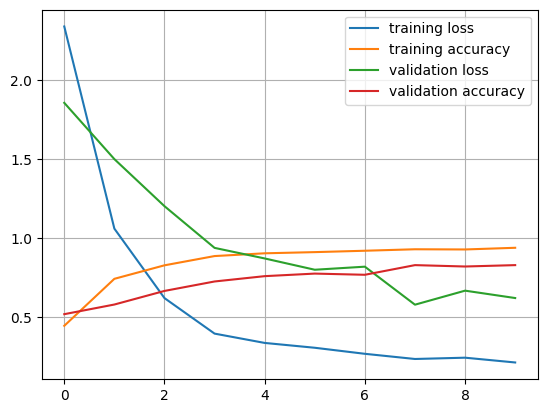

In [116]:
plt.plot(model_history.history['loss'], label = 'training loss')
plt.plot(model_history.history['acc'], label = 'training accuracy')
plt.grid(True)
plt.legend()

plt.plot(model_history.history['val_loss'], label = 'validation loss')
plt.plot(model_history.history['val_acc'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [117]:
# Evaluate the model on the Validation dataset
results = model.evaluate(val_datagen)

340/340 [==============================] - 1013s 3s/step - loss: 0.6457 - acc: 0.8180


In [ ]:
train_results = model.evaluate(train_datagen)

In [ ]:
print("Training Loss :-", train_results[0])
print("="*30)
print("Training Accuracy :-", train_results[1])

In [123]:
print("Validation Loss :-", results[0])
print("="*30)
print("Validation Accuracy :-", results[1])

Validation Loss :- 0.6456505060195923
Validation Accuracy :- 0.8180477619171143


It's essential to compare the validation loss with the training loss. If the training loss is significantly lower than the validation loss, it might suggest overfitting. Ideally, the training and validation losses should be close, indicating good generalization.

In [119]:
cd '/content/drive/My Drive/FloraGuard/models'

/content/drive/My Drive/FloraGuard/models


**Saving the Model**

In [120]:
model.save('models/pdd_mobilenet2_v1.h5')

In [121]:
cd '/content/drive/My Drive/FloraGuard/datasets'

/content/drive/My Drive/FloraGuard/datasets


# Testing the Model

In [125]:
import random
from PIL import Image
import glob

base_path = 'plantvillage dataset splitted'
idx = np.random.randint(30)
test_images_dir = os.path.join(base_path, 'test')

# Get a list of subdirectories within the test_images_dir
subdirectories = [d for d in os.listdir(test_images_dir) if os.path.isdir(os.path.join(test_images_dir, d))]

# Choose a random subdirectory
random_subdirectory = random.choice(subdirectories)

# Get a list of image files within the chosen subdirectory
image_files = glob.glob(os.path.join(test_images_dir, random_subdirectory, '*.jpg'))

if image_files:
    # Choose a random image file from the list
    random_image = random.choice(image_files)

    # Open the random image file
    test1 = Image.open(random_image)
else:
    print("No image files found in the directory:", os.path.join(test_images_dir, random_subdirectory))


Text(0.5, 1.0, 'Potato___Early_blight')

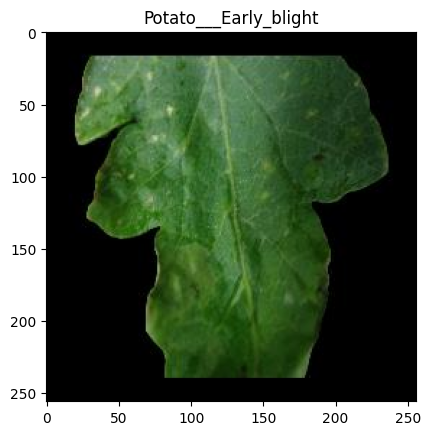

In [126]:
plt.imshow(test1)
plt.title(os.listdir(test_images_dir)[idx])

Predicting the Disease

In [1]:
test1 = test1.resize((224,224))
test1_scaled = np.expand_dims(np.asarray(test1), axis = 0) / 255
predictions = model.predict(test1_scaled)
print(predictions)

NameError: name 'test1' is not defined

In [128]:
labels = train_datagen.class_indices
labels = { v:k for (k,v) in labels.items() }
labels[np.argmax(predictions)]

'Tomato___Late_blight'

In [129]:
cd '/content/drive/MyDrive/FloraGuard'

/content/drive/MyDrive/FloraGuard


In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open("models/converted_model.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
model.summary()

In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("models/converted_model.tflite", "wb").write(tflite_model)

# Deploying with Tensorflowjs

This will be achieved by converting the Python model to a Javascript-compatible format, using ‘ tensorflowjs-converter’ — An efficient Python module that converts saved Keras models to formats compatible with Javascript.

In [ ]:
# Converting the Keras Model to Tensorflow.js compatible model
!pip install tensorflowjs

In [ ]:
pwd

In [ ]:
!mkdir tensorflowjs-model

In [ ]:
!tensorflowjs_converter --input_format keras models/pdd_mobilenet2_v1.h5 tensorflowjs-model/

In [ ]:
# Download the converted model
!zip -r tensorflowjs-model.zip tensorflowjs-model